# MULTIPLICATIVE WEIGHTS ALGORITHM

## DESCRIPTION

## EXAMPLE GAMES

In [54]:
matching_pennies = [[[1.0,-1.0], [-1.0, 1.0]], 
                    [[-1.0, 1.0], [1.0,-1.0]]]

schere_strein_papier = [[[0,0], [-1, 1], [1, -1]], 
                        [[1,-1], [0, 0], [-1, 1]],
                        [[-1,1], [1, -1], [0, 0]]]

test_game_2 = [[[0,0], [-1, 1], [1, -1]], 
              [[1,-1], [0, 0], [-1, 1]]]

prisoners_dilemma = [[[3,3], [0, 5]],
                     [[5,0], [1, 1]]]

shapley_game = [[[1,0], [0, 1], [0, 0]], 
                [[0,0], [1, 0], [0, 1]],
                [[0,1], [0, 0], [1, 0]]]

test_game = np.array([[[0,1],[2,3]],[[3,4],[5,6]]])
test_strategy = np.array([[0.06, 0.14], [0.24, 0.56]])

## ALGORITHM IMPLEMENTATION

In [55]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [56]:

# input: a strategy in the form of 
# example_input: strategy = [[0.2, 0.8], [0.3, 0.7]] for 2x2 , 2 player game 

def calculate_joint_strategy(strategy):
    p0_strategy = np.transpose([strategy[0]])
    p1_strategy =[strategy[1]]
    joint_strategy_profile = np.matmul(p0_strategy, p1_strategy)
    return joint_strategy_profile             

In [57]:
# for a 2x2, 2 player game
# example: joint strategy profile is of the form: [[0.06, 0.14], [0.24, 0.56]] 
def calculate_joint_payoff(game, joint_strategy_profile):
    return np.transpose(np.transpose(game) * np.transpose(joint_strategy_profile))
        

In [58]:
# player_no's payoff from a joint_payoff_vector 
# for a 2x2, 2 player game, example joint_payoff for matching pennis: 
# [[[0.06, -0.06], [-0.14, 0.14]], [[-0.24, 0.24], [0.56, -0.56]]]
def calculate_player_payoff(player_no, joint_payoff): 
    return sum(sum(joint_payoff))[player_no]
    

In [59]:
def no_of_actions (game, player_no): 
    return np.array(game).shape[player_no]

In [60]:
#initialize the strategy profile of both players 
# both players play each option with 1/no_actions
def initial_history_disc_uni_dist(game): 
    no_of_actions_p0 = no_of_actions (game, 0)
    no_of_actions_p1 = no_of_actions (game, 1)
    history = [([1/no_of_actions_p0] * no_of_actions_p0), ([1/no_of_actions_p1] * no_of_actions_p1)]
    return history

In [61]:
def initial_history_random_distribution(game): 
    no_of_actions_p0 = no_of_actions (game, 0)
    no_of_actions_p1 = no_of_actions (game, 1)
    random_dist_p0 = np.random.random_sample(no_of_actions_p0)
    random_dist_p1 = np.random.random_sample(no_of_actions_p1)
    #normalize 
    random_dist_p0 = random_dist_p0 / sum(random_dist_p0)
    random_dist_p1 = random_dist_p1 / sum(random_dist_p1)
    
    return [random_dist_p0.tolist(), random_dist_p1.tolist()]

In [62]:
# this function calculates the payoff of playing action_no by player_no with 1.0 
# given past_other_player_strategies
def calculate_alternate_player_payoff(game, player_no, action_no, past_other_player_strategy): 
    number_of_actions = no_of_actions(game, player_no)
    action_profile = [0.0] * number_of_actions
    action_profile[action_no] = 1.0
    strategy_profile = [past_other_player_strategy]
    strategy_profile.insert(player_no, action_profile)
    joint_strategy_profile = calculate_joint_strategy(strategy_profile)    
    joint_payoff = calculate_joint_payoff (game, joint_strategy_profile)
    return calculate_player_payoff(player_no, joint_payoff)

In [63]:
def history_beta_update(game, player_no, action_no, beta, history): 
    last_played_prob = history[player_no][action_no]
    other_player_last_played_prob = history[(1-player_no)]
    alternate_action_payoff = calculate_alternate_player_payoff(game, player_no, action_no, other_player_last_played_prob)
    result = last_played_prob * beta**-alternate_action_payoff
    return result 
    

In [64]:
def calculate_next_step(game, player_no, action_no, beta, history): 
    numerator = history_beta_update(game, player_no, action_no, beta, history)
    number_of_actions = no_of_actions(game, player_no)
    denominator = 0.0
    for action_no_2 in range(number_of_actions): 
        if action_no_2 == action_no: 
            denominator += numerator
        else: 
            denominator += history_beta_update(game, player_no, action_no_2, beta, history)
    return numerator / denominator 
    

In [65]:
def euclidean_distance(history, new_history): 
    # as history.p0.shape sometimes != history.p1.shape
    p0_hist = np.array(history[0])
    p1_hist = np.array(history[1])
    
    p0_new_hist = np.array(new_history[0])
    p1_new_hist = np.array(new_history[1])
    
    p0_distance = (p0_hist - p0_new_hist)**2
    p1_distance = (p1_hist - p1_new_hist)**2
    distance = sum(p0_distance) + sum(p1_distance)
    return math.sqrt(distance)

In [66]:
def multiplicative_weights(game, epsilon, beta, init_history): 
    histories = [init_history]
    history = init_history
    no_of_actions_p1 = no_of_actions (game, 0)
    no_of_actions_p2 = no_of_actions (game, 1)
    iters = 0
    while 1: 
        p1_strategy = [calculate_next_step(game, 0, i, beta, history) for i in range(no_of_actions_p1)]
        p2_strategy = [calculate_next_step(game, 1, i, beta, history) for i in range(no_of_actions_p2)]
        new_history = [p1_strategy, p2_strategy]
        histories.append(new_history)
        # check if multiplicative weights has converged or doesnt converge
        if  (euclidean_distance (history, new_history) <= epsilon) or iters == 1000: 
            break
        iters +=1
        history = new_history
        
    return histories

In [67]:
# returns the history of strategy profiles for player
def get_history(player_no, history): 
    return [strategy[player_no] for strategy in history]

In [68]:
def plot_history(history, game_name): 
   
    
    hist_p0 = np.transpose(get_history(0, history))
    hist_p1 = np.transpose(get_history(1, history))
    
    fig, ax = plt.subplots()
    
    for action_no, action_history_p0 in enumerate(hist_p0):
        ax.plot(range(len(action_history_p0)), action_history_p0, label ="player:0, action:{}".format(action_no))
    
    for action_no, action_history_p1 in enumerate(hist_p1):
        ax.plot(range(len(action_history_p1)), action_history_p1, label ="player:1, action:{}".format(action_no))
    
    ax.set_title("Multiplicative weights algorithm with {}".format(game_name))
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('Strategy probability')
    ax.legend()

In [69]:
def multiplicative_weights_plot(game, game_name, init_history, beta = 0.7, epsilon = 0.01): 
    history = multiplicative_weights(game,epsilon, beta, init_history)
    plot_history(history, game_name)

# FINDINGS

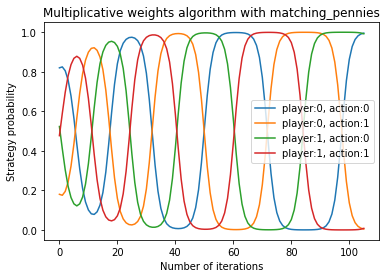

In [70]:
multiplicative_weights_plot(matching_pennies, "matching_pennies", initial_history_random_distribution(matching_pennies))

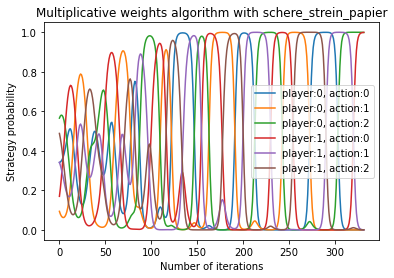

In [71]:
multiplicative_weights_plot(schere_strein_papier, "schere_strein_papier", initial_history_random_distribution(schere_strein_papier), epsilon = 0.001)

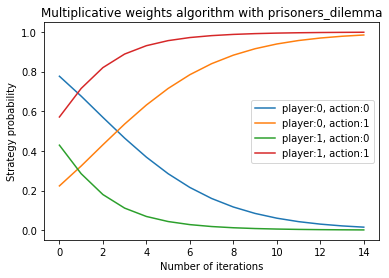

In [72]:
multiplicative_weights_plot(prisoners_dilemma,"prisoners_dilemma", initial_history_random_distribution(prisoners_dilemma))

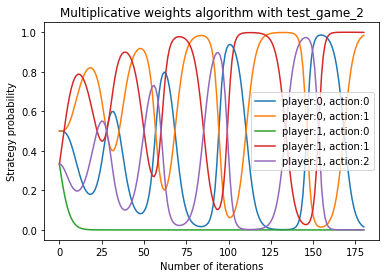

In [73]:
multiplicative_weights_plot(test_game_2, "test_game_2", initial_history_disc_uni_dist(test_game_2))

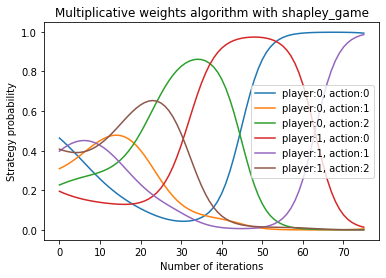

In [74]:
multiplicative_weights_plot(shapley_game, "shapley_game", initial_history_random_distribution(shapley_game))